# Network Evapo

## Part1. Fetching the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import dask.dataframe as dd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import random

In [ ]:
import zipfile

# Replace the zip_file_path with the path to the zip file in your Google Drive
zip_file_pathEvapo = '/content/drive/MyDrive/dataEvapotranspirationTensor.zip'

zip_file_paths = [zip_file_pathEvapo]

# Replace the destination_folder with the path of the folder where you want to extract the contents
destination_folderEvapo = '/content/dataEvapotranspiration'

destination_folders = [destination_folderEvapo]

In [ ]:
# Unzip the file

for i in range(len(destination_folders)):
  with zipfile.ZipFile(zip_file_paths[i], 'r') as zip_ref:
      zip_ref.extractall(destination_folders[i])


In [ ]:


sampleCoordinatesEvapoIDArrayPositionDf_file = '/content/drive/MyDrive/sampleCoordinatesEvapoIDArrayPositionDf.parquet'
sampleCoordinatesEvapoIDArrayPositionDf = dd.read_parquet(sampleCoordinatesEvapoIDArrayPositionDf_file).compute()



In [ ]:


file_path = "/content/dataEvapotranspiration/0.pt"

# Load the tensor from the file
try:
    tensor = torch.load(file_path)
    data_type = tensor.dtype
    if data_type == torch.float64:
        print("The tensor contains double values (float64).")
    elif data_type == torch.float32:
        print("The tensor contains float values (float32).")
    else:
        print("The tensor contains a different data type.")
except Exception as e:
    print("An error occurred:", e)


The tensor contains float values (float32).


### Part 2. Custom Dataset

In [ ]:
file_pathEvapo = '/content/dataEvapotranspiration/'

In [ ]:
batch_sizeEvapo = 32

In [ ]:
file_extension = '.pt'
num_workers = 2

In [ ]:

class CustomRasterDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dataFrame, file_path, file_extension,windowSize,re_scale = False,new_min = -1,new_max = 1):
        'Initialization'
        self.re_scale = re_scale
        self.new_min  = new_min
        self.new_max = new_max
        self.dataFrame = dataFrame
        self.file_path = file_path
        self.file_extension = file_extension
        self.windowSize = windowSize
        self.offset = self.windowSize // 2


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataFrame)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID =  self.dataFrame.iloc[index]['ID'] # str(ID).rstrip('.0')

        x = self.dataFrame.iloc[index]['x'] + random.choice([-2, -1, 0, 1, 2])
        y = self.dataFrame.iloc[index]['y']+ random.choice([-2, -1, 0, 1, 2])
        # Load data and get label
        fullArray = torch.load(self.file_path+ID+self.file_extension)
        # Determine the window for the square
        left = x - self.offset
        right = x + (self.offset + 1)
        top = y - self.offset
        bottom = y + (self.offset + 1)
        X = fullArray[left:right,top:bottom].clone().detach()  # Access value in gpu_dictElevation
        # if self.re_scale:
          # X =  re_scale(X,self.new_min,self.new_max)
        return X.unsqueeze(0)


In [ ]:
windowSizeEvapo= 33
# Create the dataset instance
datasetEvapo = CustomRasterDataset(sampleCoordinatesEvapoIDArrayPositionDf, file_pathEvapo, file_extension,windowSizeEvapo)

In [ ]:

# Create a DataLoader for batching and parallel data loading (you can adjust batch_size and num_workers as needed)

dataLoaderEvapo = DataLoader(datasetEvapo, batch_size=batch_sizeEvapo, num_workers=num_workers, shuffle=True)

# Now you can use elevation_dataloader in your training loop to efficiently access the elevation values in gpu_dictElevation.


In [ ]:
# Assuming you have already created the 'elevation_dataloader' as mentioned in the previous steps

# Get the first batch from the dataloader using the 'next' function
first_batch = next(iter(dataLoaderEvapo))
second_batch = next(iter(dataLoaderEvapo))
# Print the content of the first batch
print("First Batch:")
print(first_batch.shape)


First Batch:
torch.Size([32, 1, 33, 33])


## Part 3 VAE Architecture

#### Part 3.a. Evapo Loss

In [ ]:
def normalize_tensor01(tensor):
    max_val = torch.max(tensor)
    min_val = torch.min(tensor)

    # Avoid division by zero
    if max_val - min_val != 0:
        normalized_tensor = (tensor - min_val) / (max_val - min_val)
    else:
        normalized_tensor = tensor - min_val

    return normalized_tensor

In [ ]:
%%capture
!pip install torchmetrics

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze').to(device)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 20.8MB/s]


In [ ]:
l1_loss = nn.L1Loss(reduction='mean')

In [ ]:
# Define the MSE loss function
loss_fn = nn.MSELoss()

In [ ]:
loss_weight = len(sampleCoordinatesEvapoIDArrayPositionDf)/32
loss_weight

29555.59375

In [ ]:
class EvapoVAELoss(nn.Module):
    def __init__(self):
        super(EvapoVAELoss, self).__init__()

    def forward(self, reconstructed_x, x, mu, logvar):
        # Compute the Mean Squared Error (MSE) reconstruction loss
        # Create the L1 loss function
        # l1_loss_mean = l1_loss(reconstructed_x, x)
        mse_loss = loss_fn(reconstructed_x, x)
        reconstructed_x_repeated =  normalize_tensor01(reconstructed_x).repeat(1, 3, 1, 1)
        x_repeated = normalize_tensor01(x).repeat(1, 3, 1, 1)

        # Compute the Mean Squared Error (MSE) reconstruction loss
        lpips_loss = lpips(reconstructed_x_repeated, x_repeated)
        # Compute the KL divergence term
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Return the sum of the reconstruction loss and KL divergence term

        return kl_divergence , lpips_loss*loss_weight , mse_loss #(mse_loss*loss_weight) # loss_weight   # + l1_loss_mean*loss_weight*40

In [ ]:


class ResDown(nn.Module):
    """
    Residual down sampling block for the encoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class ResUp(nn.Module):
    """
    Residual up sampling block for the decoder
    """

    def __init__(self, channel_in, channel_out, kernel_size=3, scale_factor=2):
        super(ResUp, self).__init__()

        self.conv1 = nn.Conv2d(channel_in, channel_in // 2, kernel_size, 1, kernel_size // 2)
        self.bn1 = nn.BatchNorm2d(channel_in // 2, eps=1e-4)
        self.conv2 = nn.Conv2d(channel_in // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm2d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv2d(channel_in, channel_out, kernel_size, 1, kernel_size // 2)

        self.up_nn = nn.Upsample(scale_factor=scale_factor, mode="nearest")

        self.act_fnc = nn.ELU()

    def forward(self, x):
        x = self.up_nn(x)
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)

        return self.act_fnc(self.bn2(x + skip))


In [ ]:

# Define the encoder network
class EvapoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoEncoder, self).__init__()
        self.conv_in = nn.Conv2d(1, 8, 7, 1, padding=1)
        # self.dropout = nn.Dropout(p=0.3)
        self.res_down_block1 = ResDown(8, 16)
        self.res_down_block2 = ResDown(16, 32)
        self.res_down_block3 = ResDown(32,64)
        self.res_down_block4 = ResDown(64, 256)


        self.flatten = nn.Flatten()
        self.conv_mu = nn.Linear(1024, latent_dim,)
        self.conv_log_var = nn.Linear(1024, latent_dim)
        self.act_fnc = nn.ELU()


    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        # x = self.dropout(x)
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 8

        x =  self.flatten(x)
        mu = self.conv_mu(x)  # 1
        logvar = self.conv_log_var(x)  # 1

        return mu, logvar

# Define the decoder network
class EvapoDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoDecoder, self).__init__()
        self.latent_dim = latent_dim
        # self.linear = nn.Linear(self.latent_dim,self.latent_dim)
        # self.act_fnc1 = nn.ELU()
        self.conv_t_up = nn.ConvTranspose2d(latent_dim, 128, 4, 2,padding=0)
        self.act_fnc2 = nn.ELU()
        self.act_fnc = nn.ELU()

                # Adding dropout layer
        # self.dropout = nn.Dropout(p=0.3)
        self.res_up_block1 = ResUp(128, 64)
        self.res_up_block2 = ResUp(64, 32)
        self.res_up_block3 = ResUp(32,16)
        self.res_up_block4 = ResUp(16,8)
        self.res_up_block5 = ResUp(8,4)
        self.res_down_block1 = ResDown(4, 16)
        self.res_down_block2 = ResDown(16, 32)


        self.conv_out1 = nn.Conv2d(32, 1, 4, stride=1, padding=2)


    def forward(self, x):
        # x = self.act_fnc1(self.linear(x))
        x = x.view(x.shape[0], self.latent_dim, 1, 1)  # Reshape into a 5x5 tensor
        x = self.act_fnc2(self.conv_t_up(x))  # 4
        # x = self.dropout(x)
        x = self.res_up_block1(x)  # 8
        x = self.res_up_block2(x)  # 16
        x = self.res_up_block3(x)  # 32
        x = self.res_up_block4(x)  # 32
        x =  self.res_up_block5(x)
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.conv_out1(x)

        return  x

# Combine the encoder and decoder to form the VAE
class EvapoVAE(nn.Module):
    def __init__(self, latent_dim):
        super(EvapoVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = EvapoEncoder(self.latent_dim)
        self.decoder = EvapoDecoder(self.latent_dim)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar


# Instantiate the VAE with the desired latent_dim
latent_dim = 25
vae = EvapoVAE(20)

# Pass the input batch through the VAE
reconstructed_batch, mu, logvar = vae(first_batch)

# Check the output shape
print("Reconstructed batch shape:", reconstructed_batch.shape)



Reconstructed batch shape: torch.Size([32, 1, 33, 33])


In [ ]:
def count_parameters(model):
    """
    Count the number of parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The neural network model.

    Returns:
        int: Total number of parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
# model = YourNeuralNetworkClassHere(...)
# print(count_parameters(model))
count_parameters(vae)

921789

In [ ]:
mu, logvar = vae.encode(first_batch)
vae.reparameterize(mu, logvar)

tensor([[-5.3893e+00, -1.1242e+00,  4.3445e-01,  7.5686e-01,  1.9732e+00,
         -9.9134e-02, -3.1400e-01, -1.4011e+00, -1.2850e+00,  2.0672e-01,
         -4.1417e-01, -5.7780e-01, -1.5073e-01,  1.3939e+00, -7.6627e-01,
         -2.0700e+00,  7.0478e-01, -3.3586e-01,  3.0858e-01, -1.1331e-01],
        [ 4.4300e-01, -5.0357e-01, -1.3437e+00,  8.6343e-01, -2.9566e-01,
         -1.9028e+00, -1.1155e+00,  1.3867e+00, -7.5432e-01, -2.3635e+00,
         -2.3883e+00, -1.2561e+00, -8.0489e-01, -1.0237e+00,  2.6886e+00,
          1.6301e-01,  1.7211e+00, -7.7977e-01, -3.4508e+00,  1.8936e-02],
        [-8.7471e-01, -1.5010e+00, -3.2990e-01, -1.4172e+00, -1.0674e+00,
         -1.3860e+00, -1.6288e+00,  7.6421e-01, -6.7230e-01,  5.3832e-01,
         -3.1198e-01,  7.0352e-01, -1.7033e+00, -9.0879e-01, -1.3813e+00,
         -1.1095e+00,  1.6133e+00,  2.9197e+00,  1.7403e+00,  2.0091e-01],
        [-4.7991e-01,  9.8825e-01, -4.6976e-01, -1.9044e-01, -2.3962e-01,
         -3.5946e+00, -4.2284e-01, 

### Part4. Training the Evapo VAE

In [ ]:
def rescale_tensor(tensor):
    # Find the minimum and maximum values in the tensor
    min_val = tensor.min()
    max_val = tensor.max()

    # Calculate the scaling factors
    scale = 1.0 / (max_val - min_val)
    shift = -min_val * scale

    # Rescale the tensor
    rescaled_tensor = tensor * scale + shift

    return rescaled_tensor


In [ ]:
learning_rateEvapo = 0.0005


In [ ]:
latent_dimEvapo = 50

In [ ]:
import torch.nn.functional as F


In [ ]:
###

In [ ]:

# Define the function to train the VAE
def train_vae(vae, dataloader, num_epochs, learning_rate):
    # Set the model to training mode
    vae.train()

    # Define the Mean Squared Error (MSE) loss function
    criterion = EvapoVAELoss()
    mse = torch.nn.MSELoss()

    # Define the optimizer (you can experiment with different optimizers)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    total_batches = len(dataloader)
    batches_done = 0

    for epoch in range(num_epochs):
        total_loss = 0.0
        batches_done =0
        mse_loss = 0
        for batch_idx, data in enumerate(dataloader):
            # Get the batch of data and move it to the device (e.g., GPU if available)
            # inputs = data
            dimensions = data.shape

            inputs = data.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            reconstructed_batch, mu, logvar = vae(inputs)
            # Compute the MSE loss
            kl_divergence , lpips_loss , mse_loss  = criterion(reconstructed_batch, inputs,mu, logvar)
            loss =  kl_divergence + (lpips_loss*0.3 + mse_loss*0.5)*loss_weight
            # print( kl_divergence , lpips_loss , mse_loss, loss)
            # Backward pass
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Update the total loss for the epoch
            total_loss += loss.item()

            # Update the number of batches processed
            batches_done += 1
            mse_loss += F.mse_loss(normalize_tensor01(reconstructed_batch),normalize_tensor01(inputs)).item()
            # Print the progress when a tenth of the epoch is completed
            if batches_done % (len(dataloader) // 10) == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] - Progress: {batches_done}/{len(dataloader)} - Total Loss: {total_loss / (len(dataloader) // 10)},  {mse_loss/(len(dataloader) // 10)}")
                total_loss = 0
                mse_loss = 0

        # Print the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {total_loss / (len(dataloader) % 10)}")


In [ ]:
# Example usage:'device = torch.device("cuda" if torch.cuda.is_available() else "cpu")'
# Assuming you have the training data in 'train_dataloader' and a device set, e.g.,
# Instantiate the VAE with the desired latent_dim
vae = EvapoVAE(50).to(device)

# Define the number of epochs and learning rate
num_epochs = 3


In [ ]:
# Train the VAE
train_vae(vae, dataLoaderEvapo, num_epochs, learning_rateEvapo)

Epoch [1/3] - Progress: 2955/29556 - Total Loss: 121016306.87715736,  0.28809818625450134
Epoch [1/3] - Progress: 5910/29556 - Total Loss: 25250281.73536379,  0.5031076669692993
Epoch [1/3] - Progress: 8865/29556 - Total Loss: 23397774.5357022,  0.28079625964164734
Epoch [1/3] - Progress: 11820/29556 - Total Loss: 22267580.088663284,  0.31083422899246216
Epoch [1/3] - Progress: 14775/29556 - Total Loss: 21433024.402368866,  0.22214700281620026
Epoch [1/3] - Progress: 17730/29556 - Total Loss: 20857487.61184433,  0.2556355893611908
Epoch [1/3] - Progress: 20685/29556 - Total Loss: 20474068.902199663,  0.19608263671398163
Epoch [1/3] - Progress: 23640/29556 - Total Loss: 20195785.05211506,  0.2058795541524887
Epoch [1/3] - Progress: 26595/29556 - Total Loss: 19870144.5106599,  0.23430326581001282
Epoch [1/3] - Progress: 29550/29556 - Total Loss: 19600321.840947546,  0.2134729027748108
Epoch [1/3] - Loss: 18107107.833333332
Epoch [2/3] - Progress: 2955/29556 - Total Loss: 19361305.7895093

In [ ]:
train_vae(vae, dataLoaderEvapo, 2, learning_rateEvapo)

Epoch [1/2] - Progress: 2955/29556 - Total Loss: 17855305.138747886,  0.19925755262374878
Epoch [1/2] - Progress: 5910/29556 - Total Loss: 17728480.643654823,  0.25047141313552856
Epoch [1/2] - Progress: 8865/29556 - Total Loss: 17742547.675126903,  0.23874011635780334
Epoch [1/2] - Progress: 11820/29556 - Total Loss: 17730594.648730963,  0.2750154137611389
Epoch [1/2] - Progress: 14775/29556 - Total Loss: 17615080.036209814,  0.23087739944458008
Epoch [1/2] - Progress: 17730/29556 - Total Loss: 17662826.886971235,  0.18221324682235718
Epoch [1/2] - Progress: 20685/29556 - Total Loss: 17598598.251099832,  0.25092095136642456
Epoch [1/2] - Progress: 23640/29556 - Total Loss: 17529704.33739425,  0.24040497839450836
Epoch [1/2] - Progress: 26595/29556 - Total Loss: 17511167.49103215,  0.21367813646793365
Epoch [1/2] - Progress: 29550/29556 - Total Loss: 17512757.345516074,  0.23528003692626953
Epoch [1/2] - Loss: 17231227.0
Epoch [2/2] - Progress: 2955/29556 - Total Loss: 17473903.2632825

In [ ]:
torch.save(vae, 'vaeEvapo5Epoch.pt')

In [ ]:
!mv vaeEvapo5Epoch.pt "/content/drive/MyDrive/Colab Notebooks/"

### Part 5. Plotting and measuring the results of the Evapo VAE

In [ ]:
def get_random_batch(dataloader):
    # Get the total number of batches in the DataLoader
    num_batches = len(dataloader)

    # Generate a random index to select a batch
    random_batch_index = torch.randint(0, 100, (1,))

    # Iterate through the DataLoader to find the batch at the random index
    for i, batch in enumerate(dataloader):
        if i == random_batch_index:
            return batch


In [ ]:
randomBatch = get_random_batch(dataLoaderEvapo)

torch.Size([32, 1, 33, 33])
torch.Size([32, 1, 33, 33])
(32, 33, 33, 1)


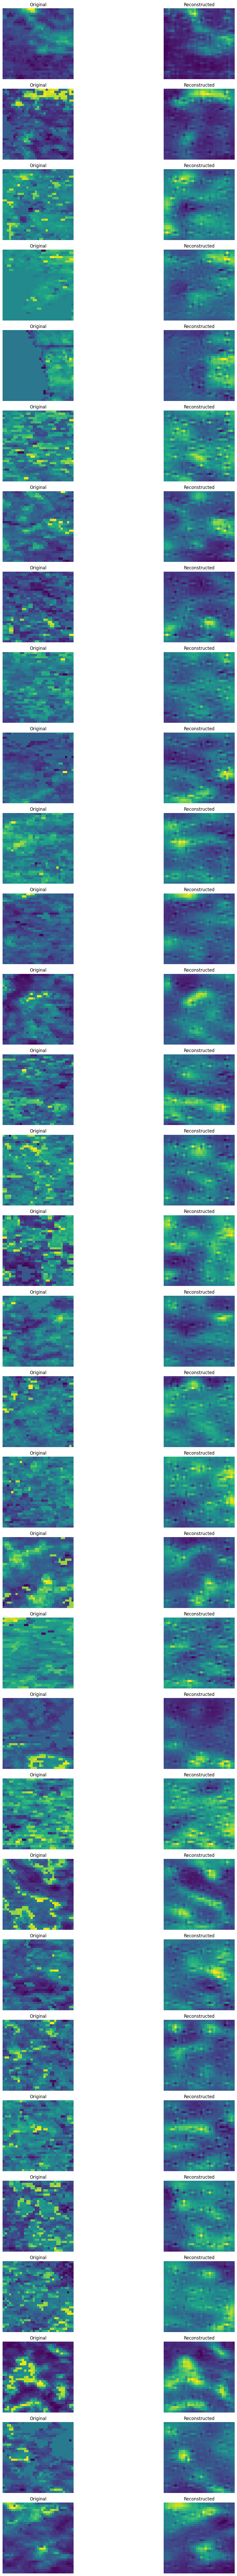

In [ ]:
import torch
import matplotlib.pyplot as plt

def compare_vae_reconstruction(vae, data_batch, device):
    # Set the VAE to evaluation mode
    vae.eval()

    # Get the batch size and number of channels
    batch_size, num_channels, height, width = data_batch.size()

    # Get the reconstructed images from the VAE
    with torch.no_grad():
        dimensions = data_batch.shape
        inputs = data_batch
        print(dimensions)

        reconstructed_batch, _, _ = vae(inputs.to(device))
    # Convert the tensors to numpy arrays and transpose the dimensions
    original_images = data_batch.cpu().numpy().transpose(0,2,3,1)
    print(reconstructed_batch.shape)
    reconstructed_images = reconstructed_batch.cpu().numpy().transpose(0,2,3,1)
    print(reconstructed_images.shape)


    # Plot the original and reconstructed images side by side
    plt.figure(figsize=(100, 100))
    for i in range(batch_size):
        plt.subplot(batch_size, 16, i*16 + 1)
        plt.imshow(original_images[i])
        plt.axis('off')
        plt.title('Original')

        plt.subplot(batch_size, 16, i*16 + 2)
        plt.imshow(reconstructed_images[i])
        plt.axis('off')
        plt.title('Reconstructed')


    plt.tight_layout()
    plt.show()

# Usage
# Assuming 'vae' is your trained Variational Autoencoder model
# and 'data_batch' is your batch of input images
# 'device' should be the device on which your model is (e.g., 'cuda' or 'cpu')
compare_vae_reconstruction(vae, randomBatch, device)


In [ ]:
import torch.nn.functional as F



def normalized_mse(tensor1, tensor2):
    # Normalize the tensors
    norm_tensor1 = normalize_tensor01(tensor1)
    norm_tensor2 = normalize_tensor01(tensor2)

    # Compute MSE
    mse_loss_normalized = F.mse_loss(norm_tensor1, norm_tensor2)
    mse_loss =  F.mse_loss(tensor1, tensor2)

    return mse_loss_normalized, mse_loss

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader



# Compute average normalized MSE for the first 100 batches
def compute_average_mse(dataloader):
    mse_values = []
    count = 0

    for data in dataloader:
        if count >= 10000:
            break

        # Generate random "predictions" just for the sake of the example
        # In a real scenario, these would be the model's output
        reconstructed_batch, _, _ = vae(data.to(device))

        mse,mse2 = normalized_mse(data.cpu(), reconstructed_batch.cpu())
        mse_values.append(mse.item())

        count += 1

    average_mse = sum(mse_values) / len(mse_values)
    print("Average Normalized MSE:", average_mse)

# Example usage
# Replace `your_dataloader` with the DataLoader you have
compute_average_mse(dataLoaderEvapo)


Average Normalized MSE: 0.005677307868376375


In [ ]:
torch.save(vae, 'vaeEvapo_final.pt')


In [ ]:
!mv vaeEvapo_final.pt "/content/drive/MyDrive/Colab Notebooks/"